In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.xkcd()
import networkx as nx
%matplotlib inline
import time
import scipy.stats as stats
import pandas as pd
import igraph as ig
from IPython.display import Image

# 1. Your Network Summary

First, load the VK fiends graph and save it

In [2]:
token = 'f95f090c3601104618d3b2eafd3d8717a3a2863447505bfcd5d658dcad61fe3356ecac784ea5bc83371a5' 
me = '72414957'

In [3]:
# to get information about friends(sex, city, education) and their ids
def get_friends_ids(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&fields=sex,city,education,lists&lang=en&access_token={}&v=5.103' 
    json_response = requests.get(friends_url.format(user_id, token)).json()
    if json_response.get('error'):
        return list()
    return json_response['response']

# to get mutual friends
def get_mutualfriends_ids(source_id, target_id):
    friends_url = 'https://api.vk.com/method/friends.getMutual?source_uid={}&target_uid={}&access_token={}&v=5.103'
    json_response = requests.get(friends_url.format(source_id, target_id, token)).json()
    if json_response.get('error'):
        return list()
    return json_response['response']

Create a graph and set node attributes:
1. name
2. sex
3. city
4. count (total number of friends)

In [4]:
friends = get_friends_ids(me)['items']
g = nx.Graph()
for friend in friends:
    friend_id = friend['id']
    friend_name = '{}_{}'.format(friend['first_name'], friend['last_name'])
    friend_sex = friend['sex']
    friend_city = friend.get('city', {'title': '-'})['title']
    friend_count = get_friends_ids(friend_id)['count']
    friend_list = friend.get('lists', [0])[0]
    time.sleep(1)
    mutualfriends_ids = get_mutualfriends_ids(me, friend_id)
    print('Processing id: ', friend_id, len(mutualfriends_ids))
    g.add_node(friend_id, attr_dict={'name': friend_name,
                                     'sex': friend_sex,
                                     'city': friend_city,
                                     'count': friend_count,
                                     'list': friend_list})
    for mutualfriend_id in mutualfriends_ids:
        g.add_edge(friend_id, mutualfriend_id)
    time.sleep(1)

Processing id:  11473724 7
Processing id:  12449126 21
Processing id:  17717866 0
Processing id:  19174936 16
Processing id:  24245569 10
Processing id:  26292231 25
Processing id:  29282974 23
Processing id:  32251522 26
Processing id:  33532336 13
Processing id:  33872367 40
Processing id:  35997842 13
Processing id:  37029945 28
Processing id:  41409351 14
Processing id:  42945341 20
Processing id:  44591424 21
Processing id:  46272832 10
Processing id:  47234107 1
Processing id:  47635005 11
Processing id:  48492156 16
Processing id:  48513983 2
Processing id:  50749585 8
Processing id:  51658813 15
Processing id:  51660688 14
Processing id:  52553113 18
Processing id:  53206056 22
Processing id:  54353316 16
Processing id:  56275818 22
Processing id:  57208397 14
Processing id:  58099781 15
Processing id:  60181752 15
Processing id:  60789368 2
Processing id:  63592363 0
Processing id:  66712308 16
Processing id:  66949880 2
Processing id:  74050909 23
Processing id:  77533159 26


In [5]:
nx.write_gml(g, 'network.gml')

Friend list labels and their values

In [6]:
lists_url = 'https://api.vk.com/method/friends.getLists?user_id={}&lang=en&access_token={}&v=5.103' 
json_response = requests.get(lists_url.format(me, token)).json()
lists = json_response['response']['items']
lists

[{'name': 'School friends', 'id': 26},
 {'name': 'University friends', 'id': 25},
 {'name': 'Family', 'id': 29}]

In [7]:
G = nx.read_gml('network.gml')

Let's draw the hole graph

C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


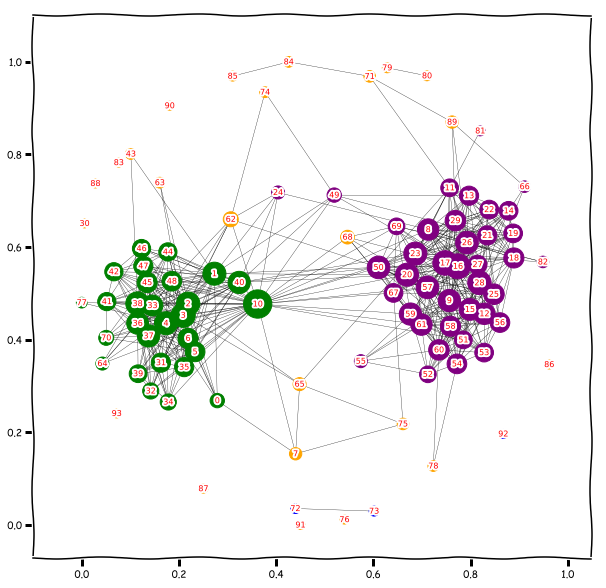

In [8]:
k = list(nx.degree(G).values())
plt.figure(1, figsize=(10, 10))
coord = nx.spring_layout(G, k=0.12, iterations=30)

# to compute size according to node degree
def size(degrees, size_max=800, size_min = 80):
    degree_max = max(degrees)
    degree_min = min(degrees)
    a = (size_max - size_min)/(degree_max - degree_min)
    b = (size_min*degree_max - size_max*degree_min)/(degree_max - degree_min)
    return [a*i + b for i in degrees]
sizes = size(k)

# colors according to friend list labels
colors = []
for i in nx.get_node_attributes(G, 'list').values():
    if i == 26:
        colors.append('green')
    elif i == 25:
        colors.append('purple')
    elif i == 29:
        colors.append('blue')
    else:
        colors.append('orange')

nx.draw_networkx(G,
                 pos=coord,
                 node_size=sizes,
                 node_color=colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

green - school friends

purple - MIPT (university) friends

blue - family

orange - others

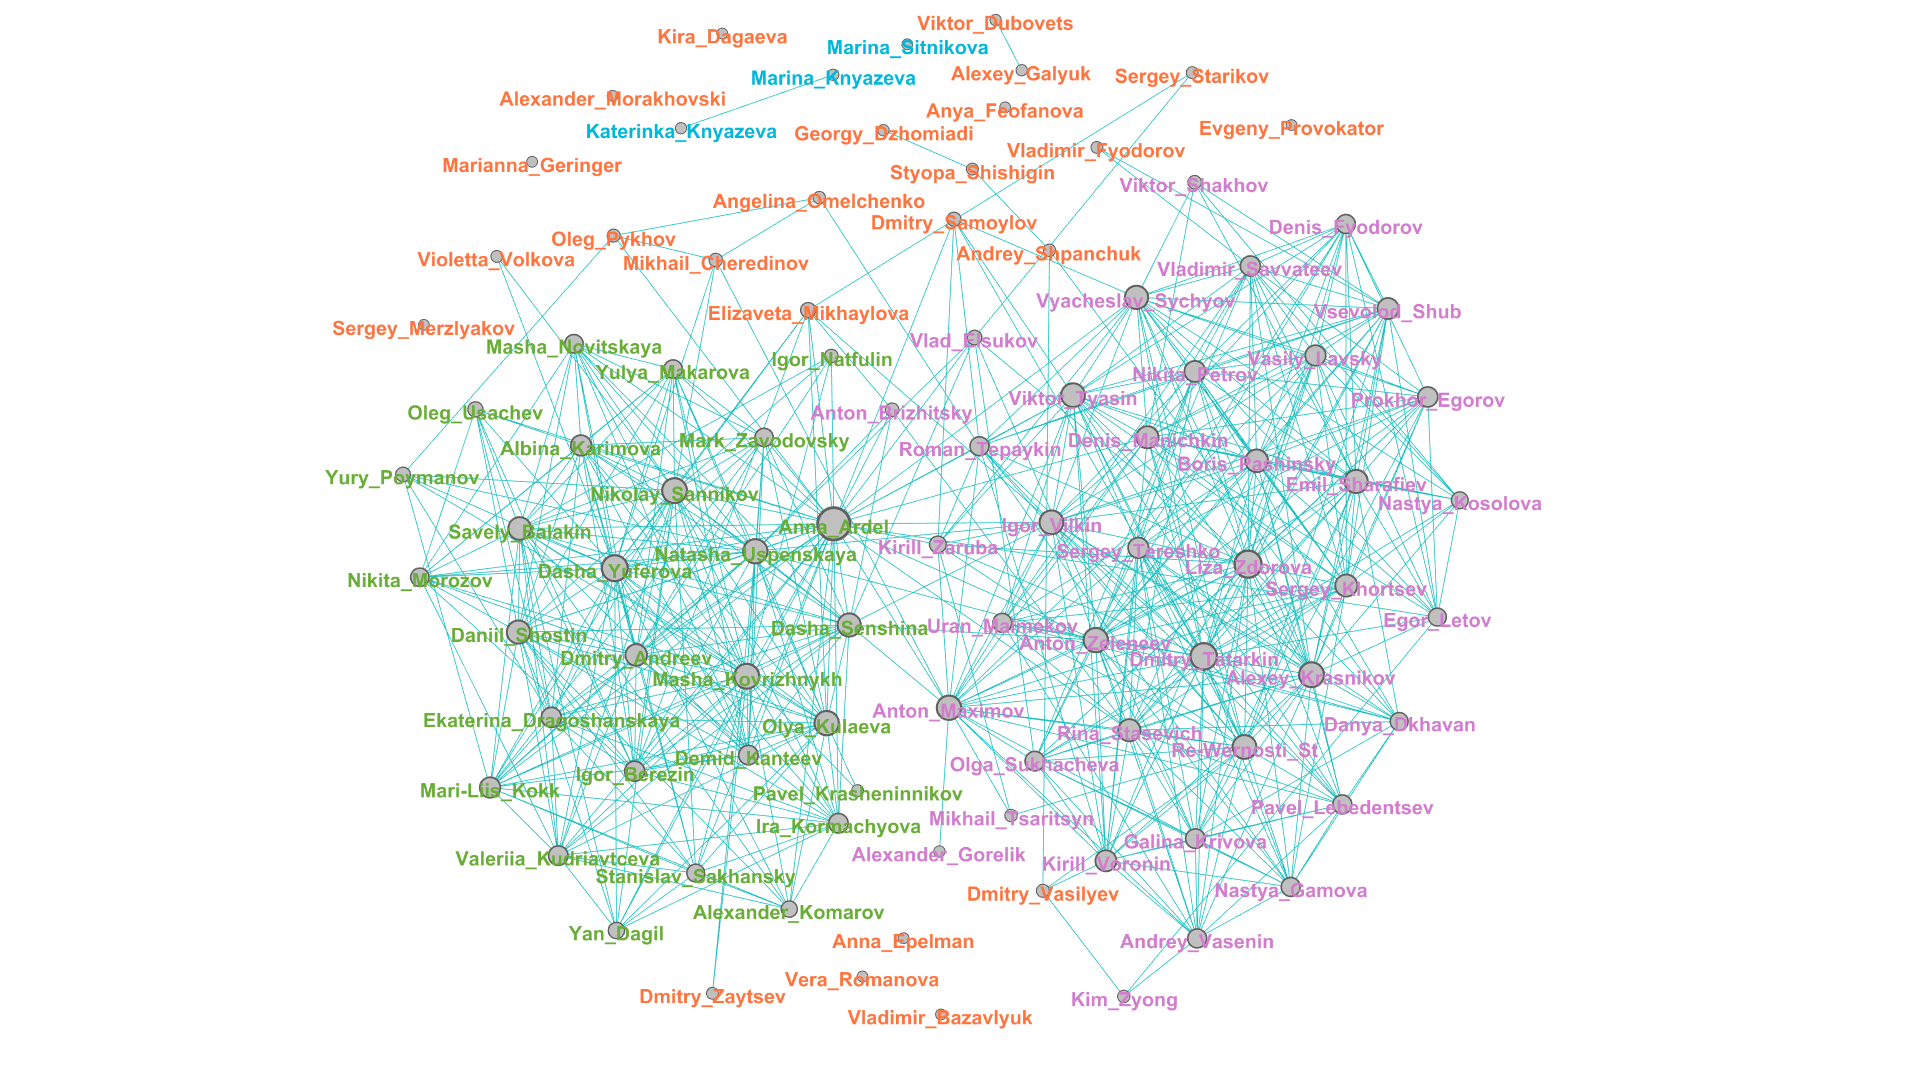

In [9]:
Image(filename='network.png') 

In [10]:
G_size = G.size()
G_order = G.order()
print('Number of nodes: {}'.format(G_order))
print('Number of edges: {}'.format(G_size))

Number of nodes: 94
Number of edges: 597


In [11]:
G_degrees = G.degree()
node_degrees = list(G_degrees.values())
yh, binEdges = np.histogram(node_degrees, 40)
bincenters = 0.5*(binEdges[1:] + binEdges[:-1])

Text(0.5,0.98,'Degree distribution')

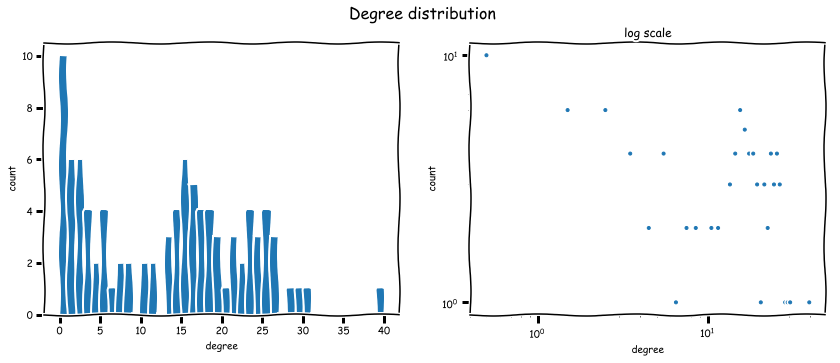

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].bar(bincenters, yh)
ax[0].set_xlabel('degree')
ax[0].set_ylabel('count')

ax[1].loglog(bincenters, yh, '.')
ax[1].set_title('log scale')
ax[1].set_xlabel('degree')
ax[1].set_ylabel('count')
fig.suptitle('Degree distribution', fontsize=16)

In [13]:
GG = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
G_diameter = nx.diameter(GG)
G_clusteringcoefficient = nx.average_clustering(G)
print('Diameter: {}'.format(G_diameter))
print('Clustering coefficient: {}'.format(G_clusteringcoefficient))

Diameter: 7
Clustering coefficient: 0.5346375683868186


# 2. Structural Analysis

Let's compute values of Degree/Closeness/Betweenness centralities and Page-Rank and visualize graph with node colors and sizes according to them.

In [14]:
degree_centrality = nx.degree_centrality(G)
dc_values = list(degree_centrality.values())
dc_sizes = size(dc_values)

In [15]:
closeness_centrality = nx.closeness_centrality(G)
cc_values = list(closeness_centrality.values())
cc_sizes = size(cc_values)

In [16]:
betweenness_centrality = nx.betweenness_centrality(G)
bc_values = list(betweenness_centrality.values())
bc_sizes = size(bc_values)

In [17]:
pagerank = nx.pagerank(G)
pr_values = list(pagerank.values())
pr_sizes = size(pr_values)

C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


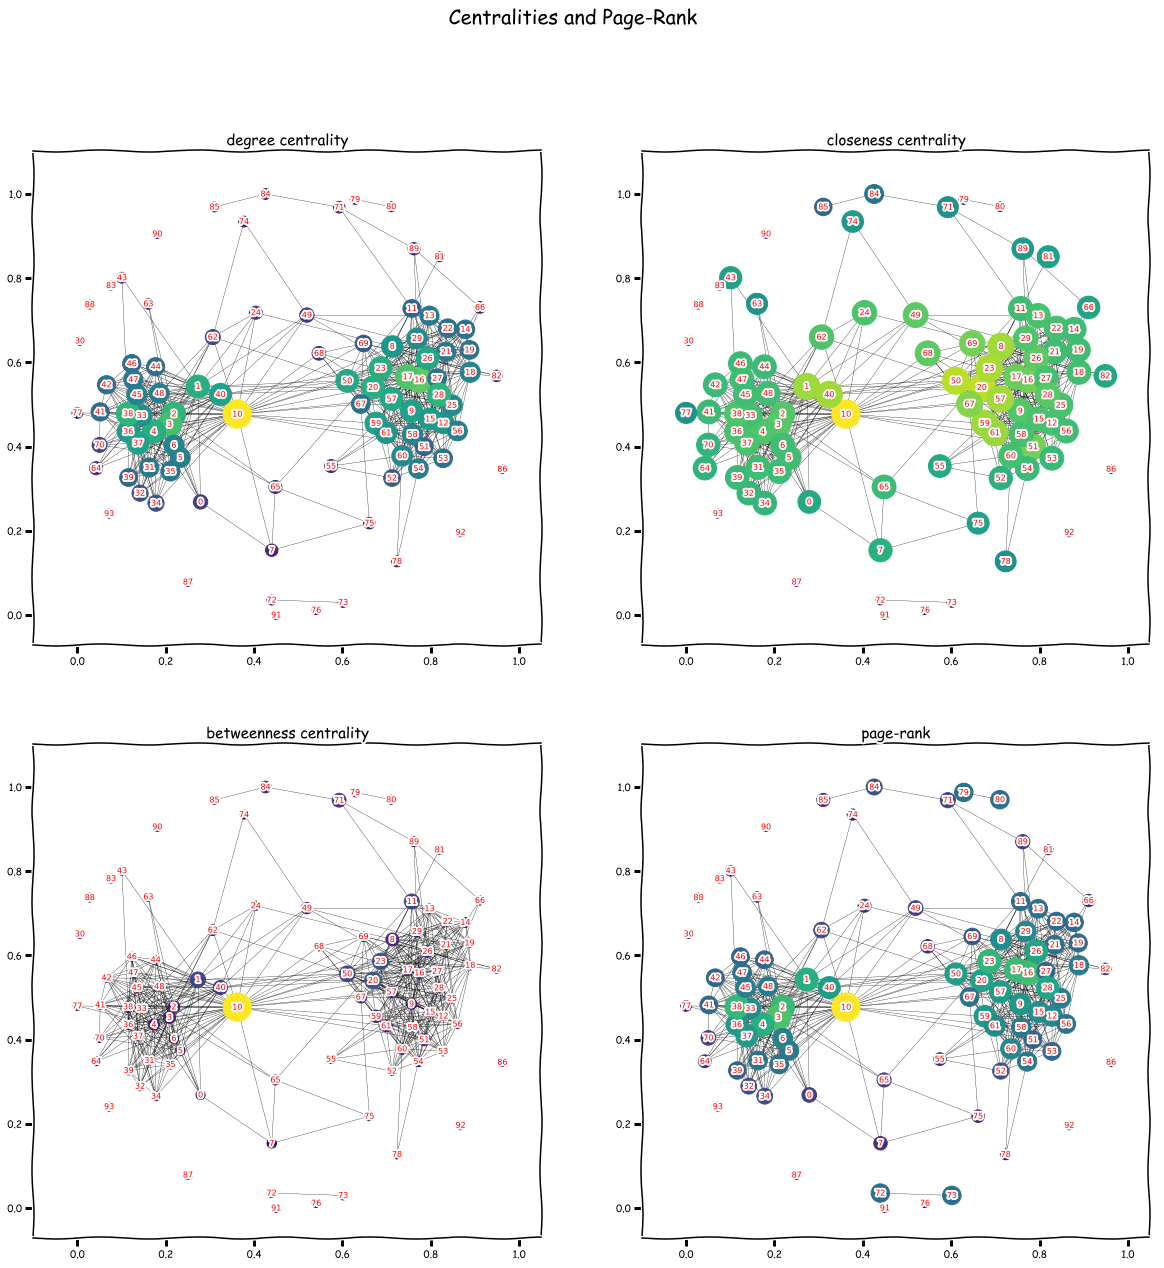

In [18]:
plt.figure(figsize=(20, 20))
plt.suptitle('Centralities and Page-Rank', fontsize=20)

plt.subplot(2,2,1)
plt.title('degree centrality', fontsize=15)
nx.draw_networkx(G,
                 pos=coord,
                 node_size=dc_sizes,
                 node_color=dc_values,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(2,2,2)  
plt.title('closeness centrality', fontsize=15)
nx.draw_networkx(G,
                 pos=coord,
                 node_size=cc_sizes,
                 node_color=cc_values,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(2,2,3)
plt.title('betweenness centrality', fontsize=15)
nx.draw_networkx(G,
                 pos=coord,
                 node_size=bc_sizes,
                 node_color=bc_values,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(2,2,4)
plt.title('page-rank', fontsize=15)
nx.draw_networkx(G,
                 pos=coord,
                 node_size=pr_sizes,
                 node_color=pr_values,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

We can see that the largest value of degree and betweenness centralities has node number 10.

The same about Page-Rank.

In [19]:
print(G.node[10]['name'])

Anna_Ardel


This girl is very communicative. She studied with me at school and MIPT too, so we have a lot of common friends. And through her pass a lot of shortest paths from school friends to university friends.

What about closeness centrality, there are many nodes with high value. I think, it's due to explicit division into 2 large clusters(school and university) and many connections inside them. Top values of closeness centrality:

In [20]:
grand_cc = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:10]
[(i, closeness_centrality[i]) for i in grand_cc]

[(10, 0.5325994196961938),
 (20, 0.4793394777265745),
 (50, 0.4759399069625563),
 (23, 0.46281053021876156),
 (57, 0.459640595080277),
 (8, 0.4565137883110234),
 (40, 0.4565137883110234),
 (1, 0.4534292356873002),
 (59, 0.4534292356873002),
 (61, 0.45038608645449957)]

In [21]:
print(G.node[10]['name'])
print(G.node[20]['name'])
print(G.node[50]['name'])

Anna_Ardel
Anton_Zeleneev
Igor_Vilkin


Comparison Page-Rank with centralities.

Text(0.5,1,'Spearman: 0.7460226658622208\nKendall’s tau: 0.582013175051625')

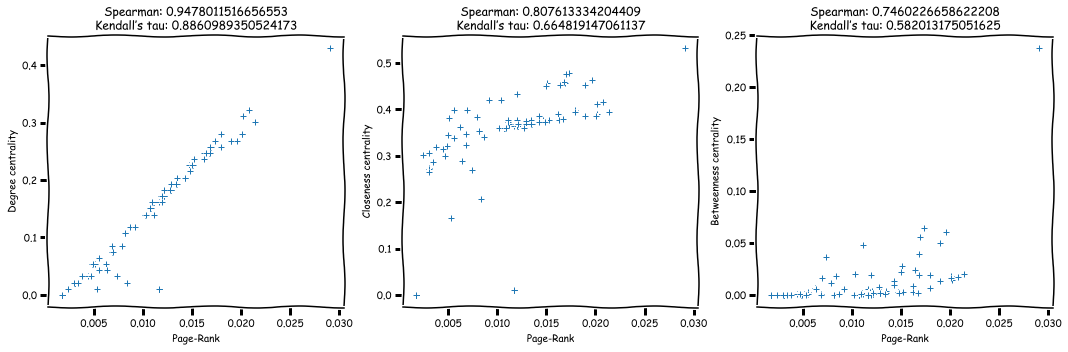

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(pr_values, dc_values, '+')
ax[0].set_xlabel('Page-Rank')
ax[0].set_ylabel('Degree centrality')
spearmanr_pr_dc = stats.spearmanr(pr_values, dc_values)
kendalltau_pr_dc = stats.kendalltau(pr_values, dc_values)
ax[0].set_title(
    'Spearman: {}\nKendall’s tau: {}'
    .format(spearmanr_pr_dc[0], kendalltau_pr_dc[0]))

ax[1].plot(pr_values, cc_values, '+')
ax[1].set_xlabel('Page-Rank')
ax[1].set_ylabel('Closeness centrality')
spearmanr_pr_cc = stats.spearmanr(pr_values, cc_values)
kendalltau_pr_cc = stats.kendalltau(pr_values, cc_values)
ax[1].set_title(
    'Spearman: {}\nKendall’s tau: {}'
    .format(spearmanr_pr_cc[0], kendalltau_pr_cc[0]))

ax[2].plot(pr_values, bc_values, '+')
ax[2].set_xlabel('Page-Rank')
ax[2].set_ylabel('Betweenness centrality')
spearmanr_pr_bc = stats.spearmanr(pr_values, bc_values)
kendalltau_pr_bc = stats.kendalltau(pr_values, bc_values)
ax[2].set_title(
    'Spearman: {}\nKendall’s tau: {}'
    .format(spearmanr_pr_bc[0], kendalltau_pr_bc[0]))

We can see positive correlation between degree centralities and Page-Rank, especially degree centrality.

Now let's compute and visualize assortative mixing acoording to node attributes.

In [23]:
assort_degree = nx.degree_assortativity_coefficient(G)
print('Assortativity coefficient for node degree: {}'.format(assort_degree))

Assortativity coefficient for node degree: -0.06875353754511968


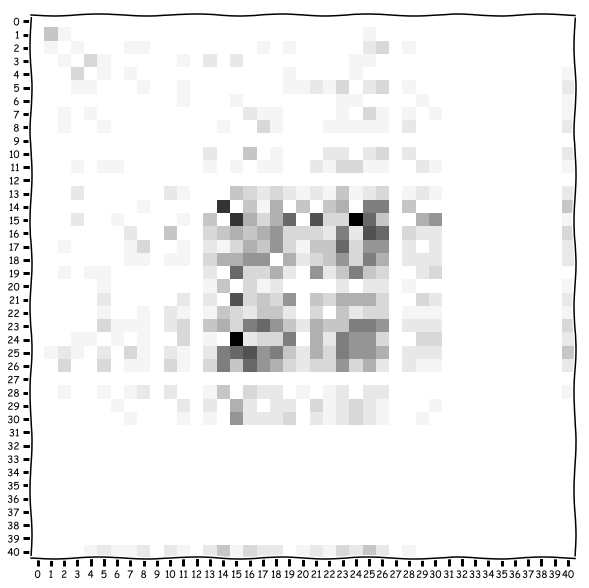

In [24]:
assortmatrix_nodedegree = nx.degree_mixing_matrix(G)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(assortmatrix_nodedegree, cmap = 'Greys')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

Non-assortative by node degree.

In [25]:
assort_sex = nx.attribute_assortativity_coefficient(G, 'sex')
print('Assortativity coefficient for sex: {}'.format(assort_sex))

Assortativity coefficient for sex: 0.08717884446672512


C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


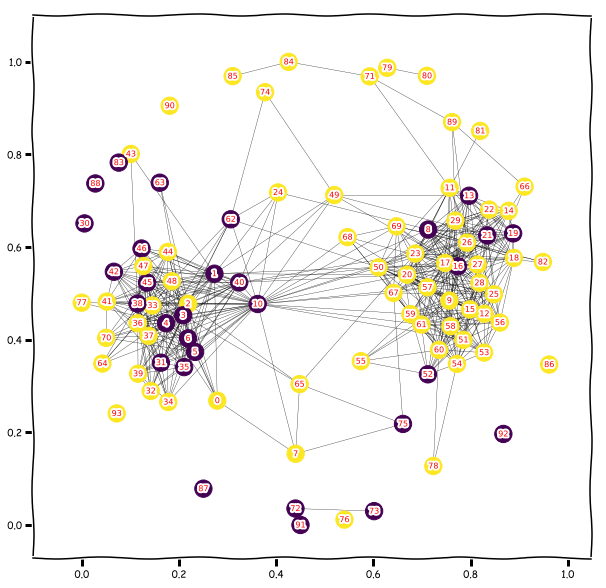

In [26]:
plt.figure(1, figsize=(10, 10))
colors = list(nx.get_node_attributes(G, 'sex').values())
nx.draw_networkx(G,
                 pos=coord,
                 #node_size=pr_sizes,
                 node_color=colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

Purple - female, yellow - male.

Non-assortative by sex. Male (about 70% of all members) prevailes in my SN.

In [27]:
assort_city = nx.attribute_assortativity_coefficient(G, 'city')
print('Assortativity coefficient for city: {}'.format(assort_city))

Assortativity coefficient for city: 0.1711095684153517


C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


([<matplotlib.axis.YTick at 0xa621f05c0>,
 <a list of 15 Text yticklabel objects>)

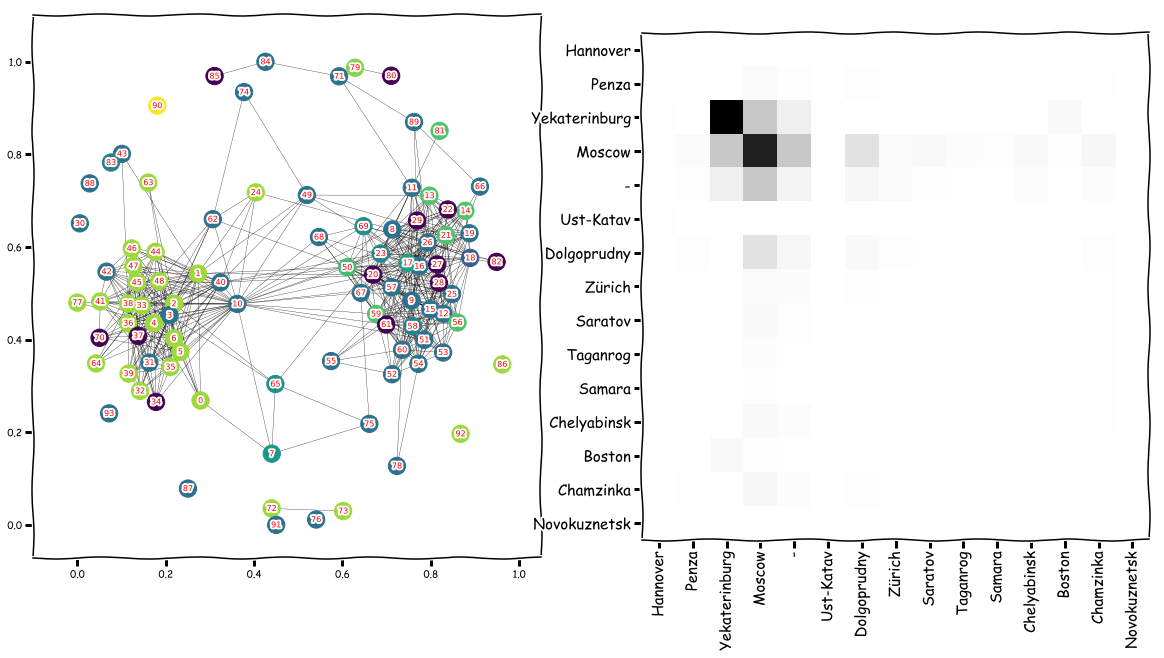

In [28]:
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
colors = []
for word in nx.get_node_attributes(G, 'city').values():
    str_word = 0
    for letter in word:
        str_word += ord(letter)
    colors.append(int(str_word))
nx.draw_networkx(G,
                 pos=coord,
                 #node_size=pr_sizes,
                 node_color=colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(1,2,2)  
assortdict_city = nx.attribute_mixing_dict(G, 'city')
city_dict = {i: n for n, i in enumerate(set(assortdict_city))}
assortmatrix_city = nx.attribute_mixing_matrix(G, 'city', mapping=city_dict)
plt.imshow(assortmatrix_city, cmap = 'Greys')
plt.xticks(list(city_dict.values()), list(city_dict.keys()), rotation='vertical', size=15)
plt.yticks(list(city_dict.values()), list(city_dict.keys()), size=15)

Here we can see something like assortative by city.

In [29]:
assort_count = nx.attribute_assortativity_coefficient(G, 'count')
print('Assortativity coefficient for total number of friends: {}'.format(assort_count))

Assortativity coefficient for total number of friends: -0.01641114415240511


C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


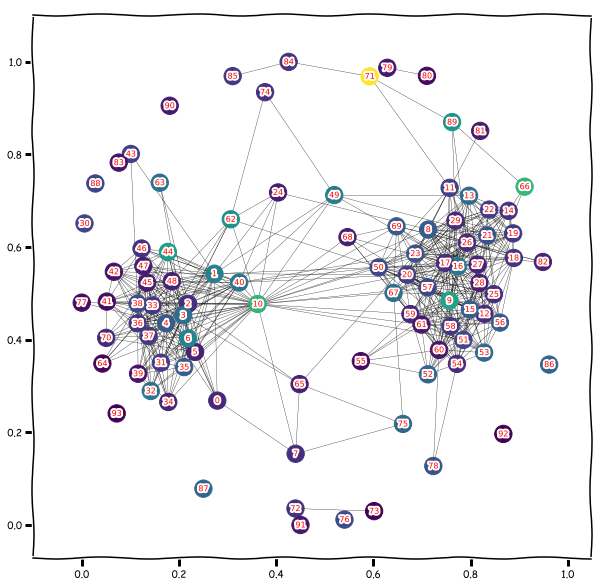

In [30]:
plt.figure(1, figsize=(10, 10))
colors = list(nx.get_node_attributes(G, 'count').values())
nx.draw_networkx(G,
                 pos=coord,
                 #node_size=pr_sizes,
                 node_color=colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

Non-assortative by total number of friends.

Let's compare structural similarity using jaccard, cosine similarity and pearson correlation coefficient.

In [31]:
adj_matrix = nx.to_numpy_matrix(G)
jaccard_matrix = np.ones((G_order, G_order))
cosine_matrix = np.ones((G_order, G_order))
pearson_matrix = np.ones((G_order, G_order))
for i in range(G_order-1):
    for j in range(i + 1, G_order):
        neigbours_i = set(G.neighbors(i))
        neigbours_j = set(G.neighbors(j))
        neigbours_union = neigbours_i | neigbours_j
        if len(neigbours_union) == 0:
            jaccard_matrix[i][j] = 0
            jaccard_matrix[j][i] = 0
        else:
            neigbours_intersection = neigbours_i & neigbours_j
            jaccard_matrix[i][j] = len(neigbours_intersection)/len(neigbours_union)
            jaccard_matrix[j][i] = jaccard_matrix[i][j]
        degree_i = G.degree(i)
        degree_j = G.degree(j)
        if degree_i == 0 or degree_j == 0:
            cosine_matrix[i][j] = 0
            cosine_matrix[j][i] = 0
            pearson_matrix[i][j] = 0
            pearson_matrix[j][i] = 0
        else:
            cosine_matrix[i][j] = len(neigbours_intersection)/np.sqrt(degree_i * degree_j)
            cosine_matrix[j][i] = cosine_matrix[i][j]
            pearson_matrix[i][j] = (len(neigbours_intersection) - degree_i*degree_j/G_order)/\
            np.sqrt(degree_i - degree_i**2/G_order)/\
            np.sqrt(degree_j - degree_j**2/G_order)
            pearson_matrix[j][i] = pearson_matrix[i][j]

Text(0.5,1,'pearson')

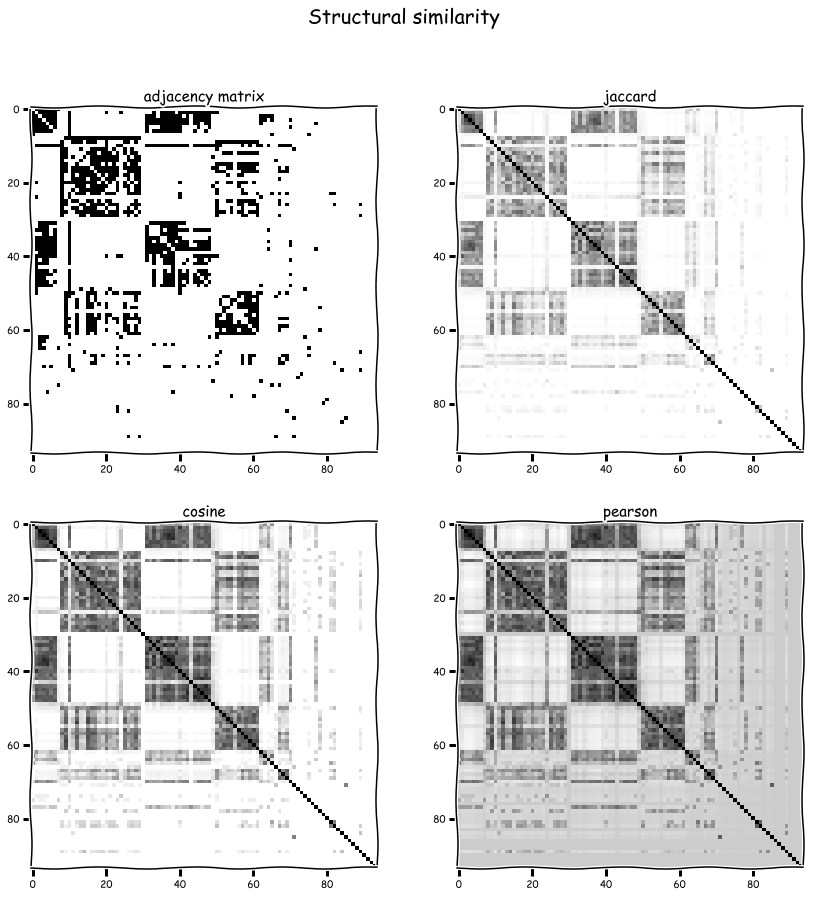

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Structural similarity', fontsize=20)

ax[0][0].imshow(adj_matrix, cmap = 'Greys')
ax[0][0].set_title('adjacency matrix', fontsize=15)

ax[0][1].imshow(jaccard_matrix, cmap = 'Greys')
ax[0][1].set_title('jaccard', fontsize=15)

ax[1][0].imshow(cosine_matrix, cmap = 'Greys')
ax[1][0].set_title('cosine', fontsize=15)

ax[1][1].imshow(pearson_matrix, cmap = 'Greys')
ax[1][1].set_title('pearson', fontsize=15)

We can conclude, that generally node is structural similar with it's neigbour.

Now I'm trying to compare my SN with 3 models of graph: Erdos-Renyi, Barabasi-Albert and Watts-Strogatz.

In Erdos-Renyi model: $$p = \frac{M}{N(N-1)/2}$$ where N - number of nodes, M - number of edges.

In [33]:
p = G_size / (G_order * (G_order - 1) / 2)
print('Erdos-Renyi model: p = {}'.format(p))
erdos = nx.erdos_renyi_graph(G_order, p)
erdos_yh, erdos_binEdges = np.histogram(list(erdos.degree().values()), 40)
erdos_bincenters = 0.5*(erdos_binEdges[1:] + erdos_binEdges[:-1])

Erdos-Renyi model: p = 0.13658201784488674


In Barabasi-Albert model: $$p = [\frac{M}{N}]$$

In [34]:
m = int(G_size / G_order)
print('Barabasi-Albert model: m = {}'.format(m))
barabasi = nx.barabasi_albert_graph(G_order, m)
barabasi_yh, barabasi_binEdges = np.histogram(list(barabasi.degree().values()), 40)
barabasi_bincenters = 0.5*(barabasi_binEdges[1:] + barabasi_binEdges[:-1])

Barabasi-Albert model: m = 6


In Watts-Strogatzmodel: $$k = 2\frac{M}{N}$$

$$p = 1 - \sqrt[3]{C\frac{4(k-1)}{3(k-2)}}$$

In [35]:
k = 2 * G_size / G_order
p = 1 - np.cbrt(G_clusteringcoefficient * 4/3 * (k - 1) / (k - 2))
print('Watts-Strogatz model: p = {}, k = {}'.format(p, k))
k = int(k)
watts = nx.watts_strogatz_graph(G_order, k, p)
watts_yh, watts_binEdges = np.histogram(list(watts.degree().values()), 40)
watts_bincenters = 0.5*(watts_binEdges[1:] + watts_binEdges[:-1])

Watts-Strogatz model: p = 0.07969671695608649, k = 12.702127659574469


In [36]:
df = pd.DataFrame({'edges': [G_size, erdos.size(), barabasi.size(), watts.size()],
                   'clustering coefficient': [G_clusteringcoefficient, nx.average_clustering(erdos),
                                              nx.average_clustering(barabasi), nx.average_clustering(watts)],
                   'diameter': [G_diameter, nx.diameter(erdos), nx.diameter(barabasi), nx.diameter(watts)]},
                      index=['SN', 'Erdos-Renyi', 'Barabasi-Albert', 'Watts-Strogatz'])
df

,edges,clustering coefficient,diameter
SN,597,0.534638,7
Erdos-Renyi,571,0.123333,3
Barabasi-Albert,528,0.207418,3
Watts-Strogatz,564,0.551816,5


Text(0.5,1,'Watts-Strogatz')

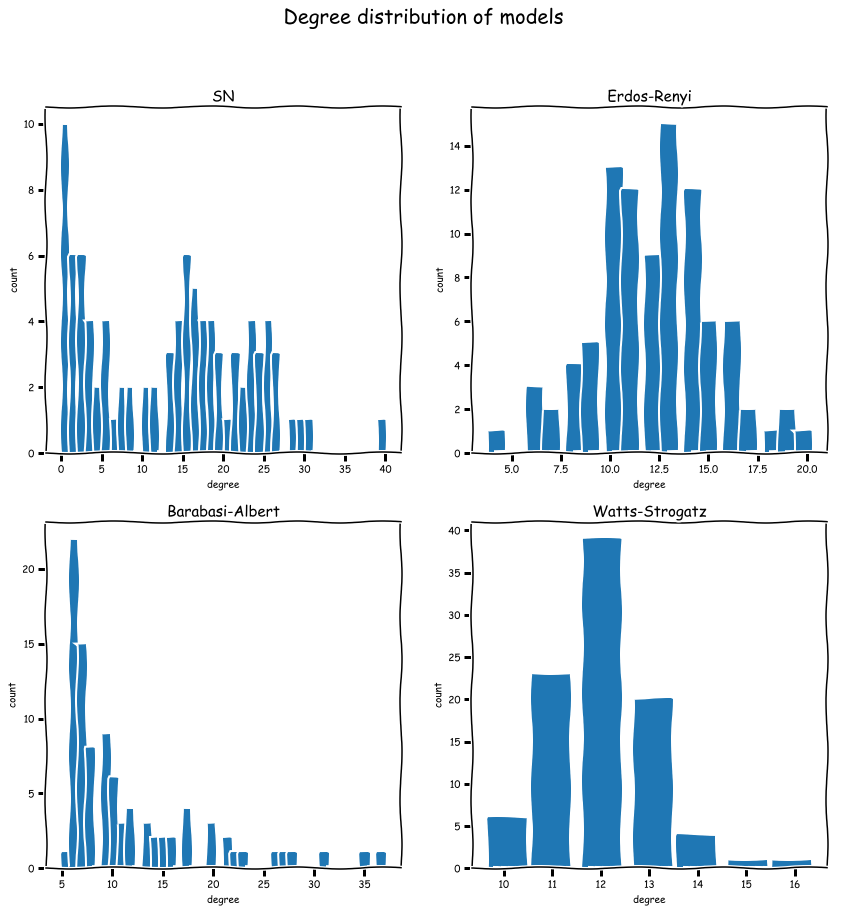

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Degree distribution of models', fontsize=20)

ax[0][0].bar(bincenters, yh)
ax[0][0].set_xlabel('degree')
ax[0][0].set_ylabel('count')
ax[0][0].set_title('SN', fontsize=15)

ax[0][1].bar(erdos_bincenters, erdos_yh)
ax[0][1].set_xlabel('degree')
ax[0][1].set_ylabel('count')
ax[0][1].set_title('Erdos-Renyi', fontsize=15)

ax[1][0].bar(barabasi_bincenters, barabasi_yh)
ax[1][0].set_xlabel('degree')
ax[1][0].set_ylabel('count')
ax[1][0].set_title('Barabasi-Albert', fontsize=15)

ax[1][1].bar(watts_bincenters, watts_yh)
ax[1][1].set_xlabel('degree')
ax[1][1].set_ylabel('count')
ax[1][1].set_title('Watts-Strogatz', fontsize=15)

According to parameters Watts-Strogatz fits best. But all degree distributions don't match my SN.

# 3. Community Detection

In [38]:
num_max_cliques = nx.graph_number_of_cliques(G)
print('Number of maximal cliques: {}'.format(num_max_cliques))

Number of maximal cliques: 227


In [39]:
size_larg_clique = nx.graph_clique_number(G)
print('Size of the largest clique: {}'.format(size_larg_clique))

Size of the largest clique: 12


In [40]:
max_cliques = sorted(nx.find_cliques(G), key=len, reverse=True)
print('Sizes of maximal cliques:')
for i in max_cliques:
    print(len(i), end=', ')

Sizes of maximal cliques:
12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [41]:
max_cliques_names = []
for q in range(3):
    clique = max_cliques[q]
    names = str(G.node[clique[0]]['name'])
    for i in clique[1:]:
        names += ', {}'.format(G.node[i]['name'])
    max_cliques_names.append(names)
print('Names in the largest cliques:')
for i in max_cliques_names:
    print(i)

Names in the largest cliques:
Anna_Ardel, Dasha_Yuferova, Olya_Kulaeva, Masha_Kovrizhnykh, Daniil_Shostin, Nikolay_Sannikov, Natasha_Uspenskaya, Dasha_Senshina, Igor_Berezin, Albina_Karimova, Dmitry_Andreev, Demid_Kanteev
Anna_Ardel, Dasha_Yuferova, Olya_Kulaeva, Masha_Kovrizhnykh, Daniil_Shostin, Nikolay_Sannikov, Natasha_Uspenskaya, Dasha_Senshina, Igor_Berezin, Albina_Karimova, Savely_Balakin, Ekaterina_Dragoshanskaya
Anna_Ardel, Dasha_Yuferova, Olya_Kulaeva, Masha_Kovrizhnykh, Daniil_Shostin, Nikolay_Sannikov, Natasha_Uspenskaya, Dasha_Senshina, Igor_Berezin, Albina_Karimova, Savely_Balakin, Demid_Kanteev


It's my schoolmates.

Let's detect community choosing number of clusters with max modularity.

In [42]:
iG = ig.read('network.gml')

I'm using grand connected component in the graph. The rest are quite small and don't contain more than 2 nodes.

In [43]:
iGCC = iG.subgraph(iG.components()[0])
GCC = nx.subgraph(G, iG.components()[0])

In [65]:
eb_dend = iGCC.community_edge_betweenness()
eb = eb_dend.as_clustering()
print('Modularity for edge betweenness algorithm: {}'.format(eb.modularity))

eb_colors = np.zeros(len(GCC), dtype=int)
for num_cl, cl in enumerate(eb):
    for i in cl:
        eb_colors[i] = num_cl

Modularity for edge betweenness algorithm: 0.4578673822470164


In [45]:
fg_dend = iGCC.community_fastgreedy()
fg = fg_dend.as_clustering()
print('Modularity for fastgreedy algorithm: {}'.format(fg.modularity))

fg_colors = np.zeros(len(GCC), dtype=int)
for num_cl, cl in enumerate(fg):
    for i in cl:
        fg_colors[i] = num_cl

Modularity for fastgreedy algorithm: 0.4599632794294187


In [46]:
wt_dend = iGCC.community_walktrap()
wt = wt_dend.as_clustering()
print('Modularity for walktrap algorithm: {}'.format(wt.modularity))

wt_colors = np.zeros(len(GCC), dtype=int)
for num_cl, cl in enumerate(wt):
    for i in cl:
        wt_colors[i] = num_cl

Modularity for walktrap algorithm: 0.4569507803121248


C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\andre_000\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


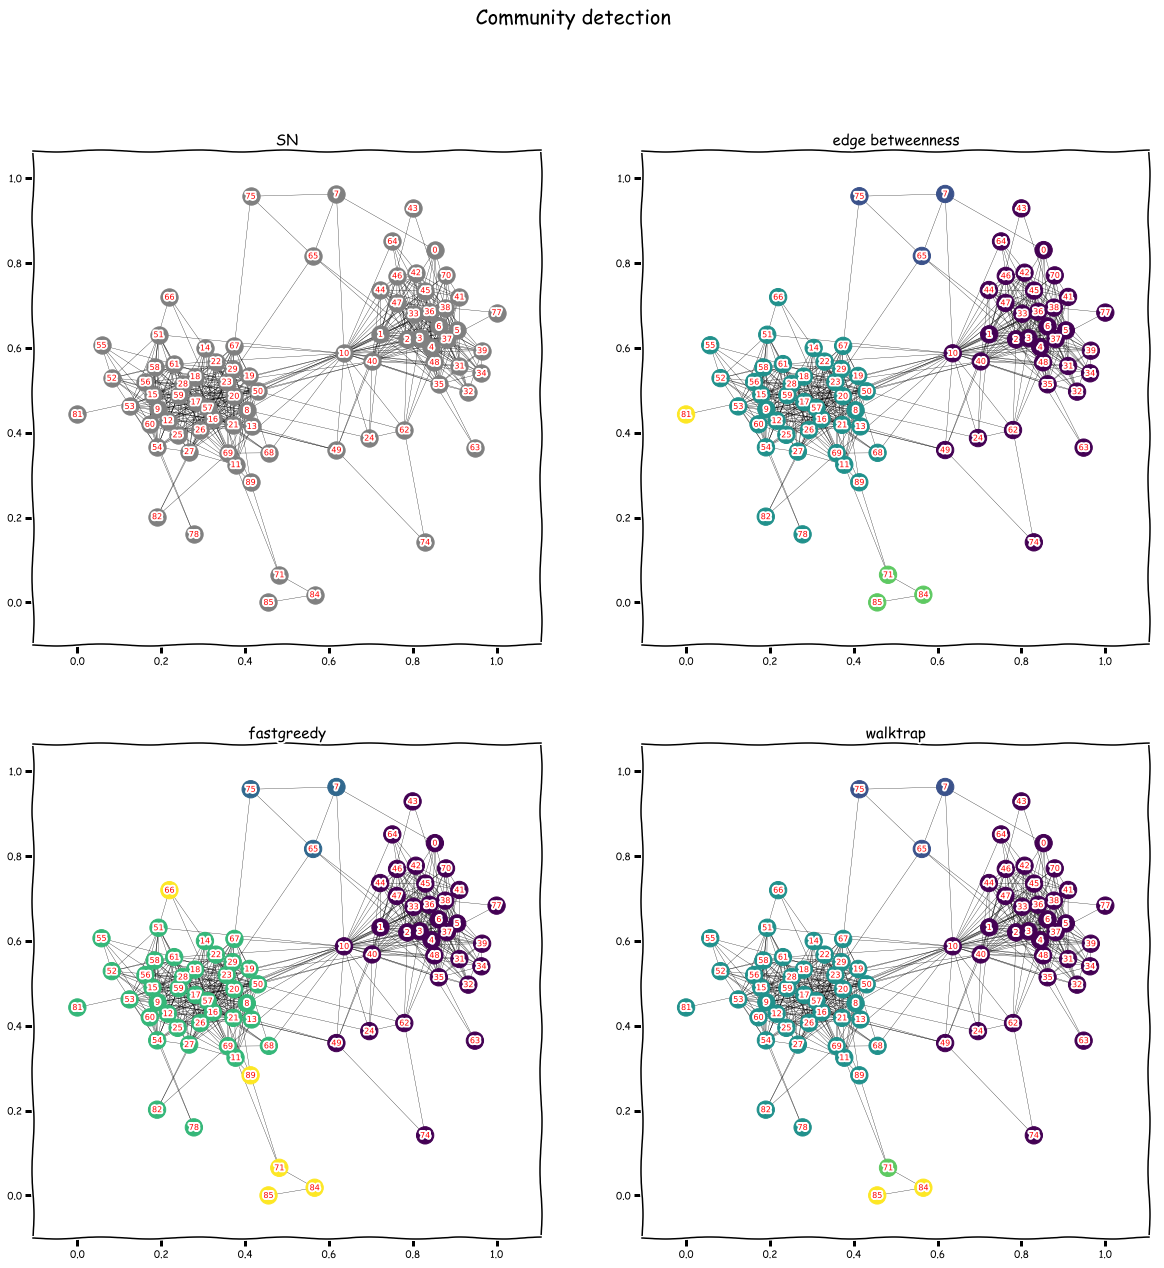

In [66]:
plt.figure(figsize=(20, 20))
plt.suptitle('Community detection', fontsize=20)
coord = nx.spring_layout(GCC, k=0.12, iterations=30)

plt.subplot(2,2,1)
plt.title('SN', fontsize=15)
nx.draw_networkx(GCC,
                 pos=coord,
                 node_color = 'grey',
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(2,2,2)  
plt.title('edge betweenness', fontsize=15)
nx.draw_networkx(GCC,
                 pos=coord,
                 node_color = eb_colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(2,2,3)
plt.title('fastgreedy', fontsize=15)
nx.draw_networkx(GCC,
                 pos=coord,
                 node_color = fg_colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

plt.subplot(2,2,4)
plt.title('walktrap', fontsize=15)
nx.draw_networkx(GCC,
                 pos=coord,
                 node_color = wt_colors,
                 width=0.3,
                 font_size=8,
                 font_color='red'
                 )

All algorithms have the largest modularity at 5 clusters and this value is high.

In [62]:
for i in (66, 89, 81, 71, 75, 7, 65, 84, 85):
    print(i, nx.get_node_attributes(G, 'name')[i])

66 Kim_Zyong
89 Dmitry_Vasilyev
81 Alexander_Gorelik
71 Andrey_Shpanchuk
75 Angelina_Omelchenko
7 Oleg_Pykhov
65 Mikhail_Cheredinov
84 Styopa_Shishigin
85 Georgy_Dzhomiadi


Based on the names of these people, I can say that the edge betweenes algorithm is clustered the best in this case.

71, 84, 85 - HSE

75, 7, 65 - physical camp "Lynx"

81 - near MIPT and "Lynx"